<a href="https://colab.research.google.com/github/crystal-zhu/Sitcom_Success_Factors-CSDS_312/blob/main/Sitcom_Success_Factors_The_Office.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-processing and Data Cleaning


In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob
import os.path
import gensim
from gensim import corpora
from gensim.models import LsiModel
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer


nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download("averaged_perceptron_tagger")

from nltk.tokenize import word_tokenize
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sb
import numpy as np
from textblob import TextBlob
import re

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Different from the other shows we are analyzing, we don't need to webscrape for the scripts as there is already a .csv with all the dialogue. Thus, the following code will just take this .csv and transform it into a dataframe for analysis.

For the CUDA implementation in Google Colab.

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

In [ ]:
import cudf

In [ ]:
# !python --version
# !nvcc --version
# !pip install nvcc4jupyter
# %load_ext nvcc4jupyter

In [ ]:
url = "https://raw.githubusercontent.com/crystal-zhu/Sitcom_Success_Factors-CSDS_312/main/The_Office_Analysis/The_Office_Lines.csv"
response = requests.get(url)

In [ ]:
# Check if the request was successful (status code 200)
if response.status_code == 200:
    with open("The_Office_Lines.csv", "w") as f:
        f.write(response.text)
    print("CSV file downloaded successfully")
else:
    print("Failed to download CSV file. Status code:", response.status_code)

df = pd.read_csv("The_Office_Lines.csv")
# Renaming the column headers to match other shows' variables and processing irrelevant columns
df.rename(columns={"line_text": "dialogue", "speaker": "character"}, inplace=True)
df.drop(columns=["scene"], inplace=True)

df['deleted'].replace('TRUE', np.nan, inplace=True)
df.dropna(subset=['deleted'], inplace=True)
df.drop(columns=["deleted"], inplace=True)

CSV file downloaded successfully


In [ ]:
# Functions we will use throughout the notebook to process and analyze the data
def preprocess_data(doc_set):
    """
    Preprocess text (tokenize, remove stopwords).
    """
    tokenizer = RegexpTokenizer(r"\b\w+(?:'\w+)?\b")  # Tokenizer to extract words with or without apostrophes
    en_stop = set(stopwords.words("english"))  # English stopwords
    custom_stopwords = set(['oh', 'go', 'uh', 'im', 'ok', 'yeah', 'okay', 'dont', 'um', 'get', 'go', 'know', "i'm"])
    en_stop = en_stop.union(custom_stopwords)


    texts = []  # List to hold tokenized and preprocessed texts

    # Loop through the document list
    for doc in doc_set:
        raw = doc.lower()  # Convert to lowercase
        tokens = tokenizer.tokenize(raw)  # Tokenize into words
        stopped_tokens = [t for t in tokens if t not in en_stop]  # Remove stopwords
        texts.append(stopped_tokens)  # Append preprocessed text to list

    return texts # Output: List in all lowercase with no apostrophes

def preprocess_dialog(dialog):
    """
    Preprocess text (tokenize, remove stopwords).
    """
    tokenizer = RegexpTokenizer(r"\b\w+(?:'\w+)?\b")  # Tokenizer to extract words with or without apostrophes
    en_stop = set(stopwords.words("english"))  # English stopwords

    # Add custom stopwords
    custom_stopwords = set(['oh', 'go', 'uh', 'im', 'ok', 'yeah', 'okay', 'dont', 'um', 'get', 'go', 'know'])
    en_stop = en_stop.union(custom_stopwords)

    dialog = dialog.lower()  # Convert to lowercase
    tokens = tokenizer.tokenize(dialog)  # Tokenize into words
    stopped_tokens = [t for t in tokens if t not in en_stop]  # Remove stopwords
    processed_dialog = ' '.join(stopped_tokens) #put the tokens back into a big string

    return processed_dialog # Output: Single string of preprocessed dialogue for each episode

def remove_special_characters(text):
    # Remove special characters and apostrophes using regex
    cleaned_text = re.sub(r"[^a-zA-Z\s']", '', text)
    return cleaned_text

def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist] # Combines all the elements from the sublists into a single, one-dimensional list.

def combine_dialogue(dialogues):
    return ' '.join(dialogues)

def get_top_20_words(word_list):
    word_counts = Counter(word_list)  # Count frequency of each word
    return word_counts.most_common(20)  # Return the top 20 most common words

In [ ]:
cleaned_df = df.copy()
%time cleaned_df['dialogue'] = cleaned_df['dialogue'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

cudf_df = cudf.DataFrame.from_pandas(df)
%time cudf_df['dialogue'] = cudf_df['dialogue'].str.replace(r'[^a-zA-Z\s]', '')
cudf_df

CPU times: user 254 ms, sys: 2 ms, total: 256 ms
Wall time: 261 ms
CPU times: user 39.7 ms, sys: 0 ns, total: 39.7 ms
Wall time: 39.7 ms


,id,season,episode,dialogue,character
0,1,1,1,All right Jim Your quarterlies look very good ...,Michael
1,2,1,1,Oh I told you I couldnt close it So,Jim
2,3,1,1,So youve come to the master for guidance Is th...,Michael
3,4,1,1,Actually you called me in here but yeah,Jim
4,5,1,1,All right Well let me show you how its done,Michael
...,...,...,...,...,...
59904,59905,9,23,It all seems so very arbitrary I applied for a...,Creed
59905,59906,9,23,I just feel lucky that I got a chance to share...,Meredith
59906,59907,9,23,Im happy that this was all filmed so I can rem...,Phyllis
59907,59908,9,23,I sold paper at this company for years My job...,Jim


In [ ]:
# Filtering a data frame for lines said by main and side characters
main_char = df.character.isin(['Michael','Dwight','Andy','Jim','Pam'])
main_char_df = df[main_char]
side_char_df = df[~main_char]

# Unnormalized data seperated for main character's dialogue
# Filter the DataFrame to select only Michael's lines

michael_lines = main_char_df[main_char_df['character'] == 'Michael'].copy()
dwight_lines = main_char_df[main_char_df['character'] == 'Dwight'].copy()
andy_lines = main_char_df[main_char_df['character'] == 'Andy'].copy()
jim_lines = main_char_df[main_char_df['character'] == 'Jim'].copy()
pam_lines = main_char_df[main_char_df['character'] == 'Pam'].copy()

michael_text = list(main_char_df[main_char_df.character == 'Michael'].dialogue)
dwight_text = list(main_char_df[main_char_df.character == 'Dwight'].dialogue)
andy_text = list(main_char_df[main_char_df.character == 'Andy'].dialogue)
jim_text = list(main_char_df[main_char_df.character == 'Jim'].dialogue)
pam_text = list(main_char_df[main_char_df.character == 'Pam'].dialogue)

In [ ]:
# michael_lines['norm_dialogue'] = michael_lines['dialogue'].apply(preprocess_dialog)

In [ ]:
main_char_df

,id,season,episode,dialogue,character
0,1,1,1,All right Jim. Your quarterlies look very good...,Michael
1,2,1,1,"Oh, I told you. I couldn't close it. So...",Jim
2,3,1,1,So you've come to the master for guidance? Is ...,Michael
3,4,1,1,"Actually, you called me in here, but yeah.",Jim
4,5,1,1,"All right. Well, let me show you how it's done.",Michael
...,...,...,...,...,...
59885,59886,9,23,I spent so much of my time here at Dunder Miff...,Andy
59889,59890,9,23,Imagine going back and watching a tape of your...,Jim
59891,59892,9,23,Thanks Phyl.,Jim
59907,59908,9,23,I sold paper at this company for 12 years. My ...,Jim


In [ ]:
# Lines are unnormalized for sentiment analysis case
michael_lines = michael_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
dwight_lines = dwight_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
andy_lines = andy_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
jim_lines = jim_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()
pam_lines = pam_lines.groupby(['season', 'episode']).agg({'dialogue': combine_dialogue}).reset_index()

# List of all the words a character says for word/ topic analysis
michael_words = flatten_list(preprocess_data(michael_text))
dwight_words = flatten_list(preprocess_data(dwight_text))
andy_words = flatten_list(preprocess_data(andy_text))
jim_words = flatten_list(preprocess_data(jim_text))
pam_words = flatten_list(preprocess_data(pam_text))

# Independent Show Analytics

## Sentiment Analysis


In [ ]:
def average_sentence_sentiment(dialogue):
    sia = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(dialogue)  # Tokenize dialogue into sentences
    sentiment_scores = [sia.polarity_scores(sentence)['compound'] for sentence in sentences]  # Calculate sentiment scores for each sentence
    if sentiment_scores:  # Check if there are any sentences
        return np.mean(sentiment_scores)  # Return the average sentiment score
    else:
        return 0  # Return 0 if there are no sentences (empty dialogue)

def sentiment_classification(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'


In [ ]:
# print(len(michael_text))

In [ ]:
michael_lines['sentiment_score'] = michael_lines['dialogue'].apply(average_sentence_sentiment)
dwight_lines['sentiment_score'] = dwight_lines['dialogue'].apply(average_sentence_sentiment)
andy_lines['sentiment_score'] = andy_lines['dialogue'].apply(average_sentence_sentiment)
jim_lines['sentiment_score'] = jim_lines['dialogue'].apply(average_sentence_sentiment)
pam_lines['sentiment_score'] = pam_lines['dialogue'].apply(average_sentence_sentiment)

michael_sentiment_stats = michael_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
dwight_sentiment_stats = dwight_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
andy_sentiment_stats = andy_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
jim_sentiment_stats = jim_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])
pam_sentiment_stats = pam_lines.groupby('season')['sentiment_score'].agg(['mean', 'std'])

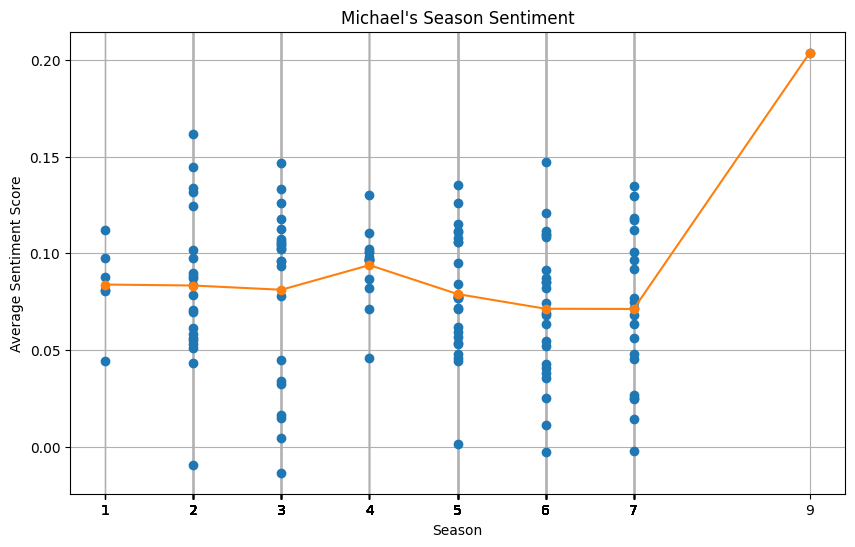

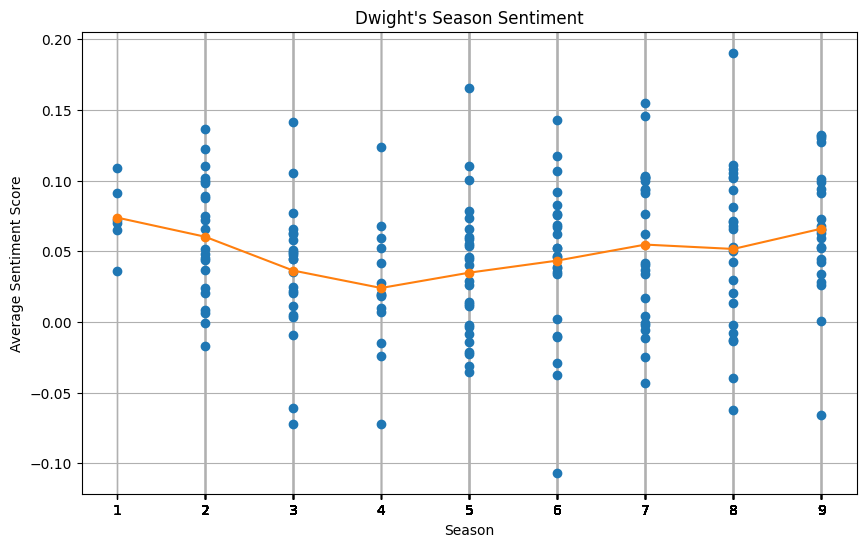

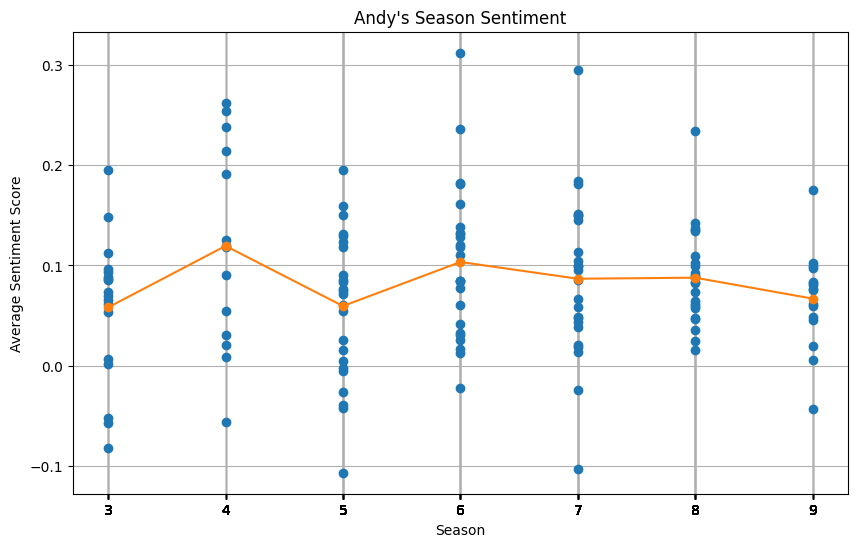

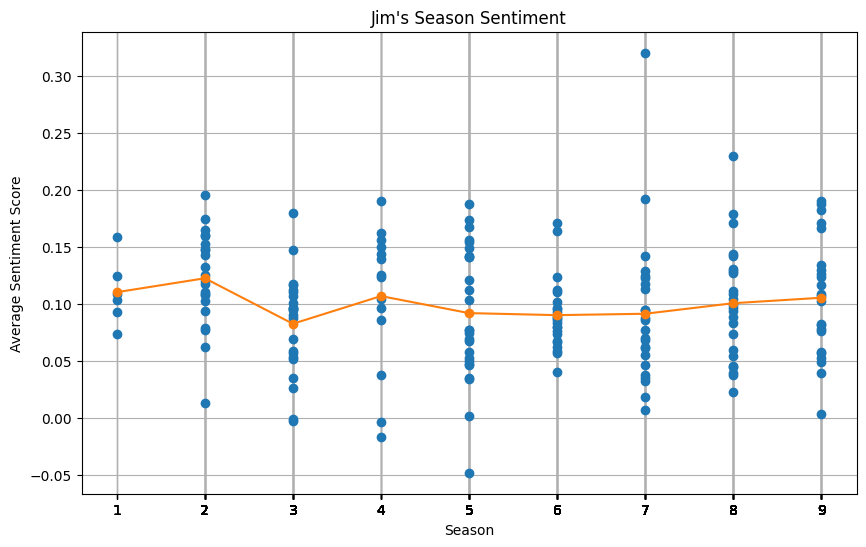

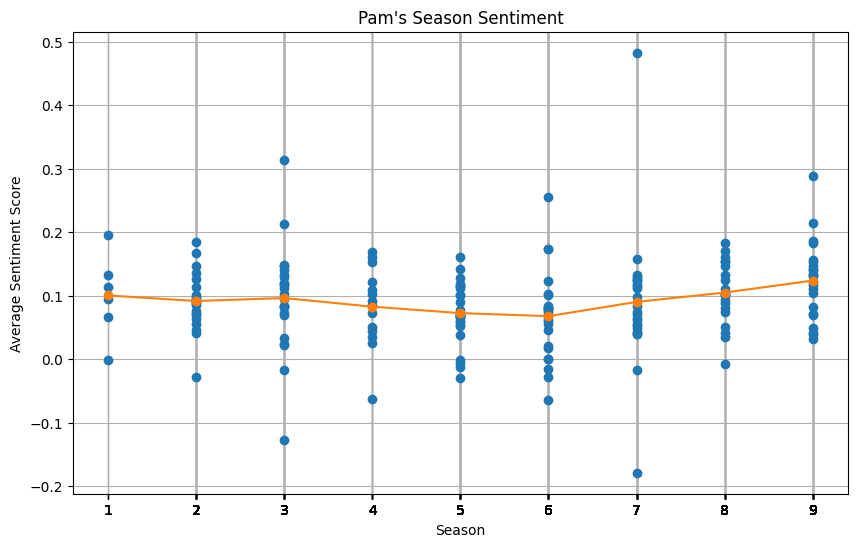

In [ ]:
# Plot season sentiment for each character

# Plot season sentiment for Michael
plt.figure(figsize=(10, 6))
plt.plot(michael_lines['season'], michael_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(michael_sentiment_stats.index, michael_sentiment_stats['mean'], marker='o')
plt.title("Michael's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(michael_lines['season'])
plt.grid(True)
plt.show()


# Plot season sentiment for Dwight
plt.figure(figsize=(10, 6))
plt.plot(dwight_lines['season'], dwight_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(dwight_sentiment_stats.index, dwight_sentiment_stats['mean'], marker='o')
plt.title("Dwight's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(dwight_lines['season'])
plt.grid(True)
plt.show()

# Plot season sentiment for Andy
plt.figure(figsize=(10, 6))
plt.plot(andy_lines['season'], andy_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(andy_sentiment_stats.index, andy_sentiment_stats['mean'], marker='o')
plt.title("Andy's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(andy_lines['season'])
plt.grid(True)
plt.show()

# Plot season sentiment for Jim
plt.figure(figsize=(10, 6))
plt.plot(jim_lines['season'], jim_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(jim_sentiment_stats.index, jim_sentiment_stats['mean'], marker='o')
plt.title("Jim's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(jim_lines['season'])
plt.grid(True)
plt.show()

# Plot season sentiment for Pam
plt.figure(figsize=(10, 6))
plt.plot(pam_lines['season'], pam_lines['sentiment_score'],linestyle='None', marker='o')
plt.plot(pam_sentiment_stats.index, pam_sentiment_stats['mean'], marker='o')
plt.title("Pam's Season Sentiment")
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(pam_lines['season'])
plt.grid(True)
plt.show()


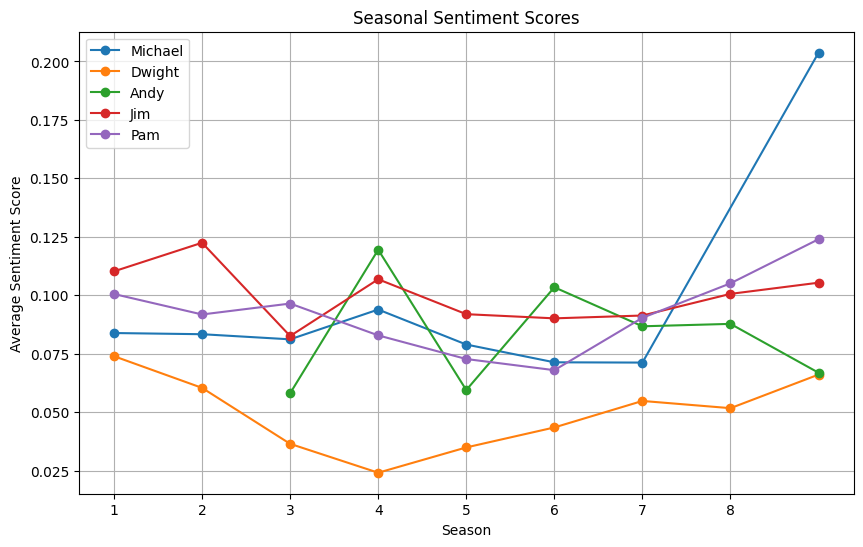

In [ ]:
# Plot mean sentiment scores
plt.figure(figsize=(10, 6))

plt.plot(michael_sentiment_stats.index, michael_sentiment_stats['mean'], marker='o', label='Michael')
plt.plot(dwight_sentiment_stats.index, dwight_sentiment_stats['mean'], marker='o', label='Dwight')
plt.plot(andy_sentiment_stats.index, andy_sentiment_stats['mean'], marker='o', label='Andy')
plt.plot(jim_sentiment_stats.index, jim_sentiment_stats['mean'], marker='o', label='Jim')
plt.plot(pam_sentiment_stats.index, pam_sentiment_stats['mean'], marker='o', label='Pam')

plt.title('Seasonal Sentiment Scores')
plt.xlabel('Season')
plt.ylabel('Average Sentiment Score')
plt.xticks(np.arange(1, 9))
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Plot average sentiment for each episode for every season (change michael to who you want this makes lots of graphs)

"""
for season_number in michael_lines['season'].unique():
    # Filter data for the current season
    season_data = michael_lines[michael_lines['season'] == season_number]

    # Plot average sentiment for each episode within the current season
    plt.figure(figsize=(10, 6))
    plt.plot(season_data['episode'], season_data['sentiment_score'], marker='o')
    plt.title("Average Sentiment for Each Episode in Season " + str(season_number))
    plt.xlabel('Episode')
    plt.ylabel('Average Sentiment Score')
    plt.xticks(season_data['episode'])
    plt.grid(True)
    plt.show()
"""

'\nfor season_number in michael_lines[\'season\'].unique():\n    # Filter data for the current season\n    season_data = michael_lines[michael_lines[\'season\'] == season_number]\n\n    # Plot average sentiment for each episode within the current season\n    plt.figure(figsize=(10, 6))\n    plt.plot(season_data[\'episode\'], season_data[\'sentiment_score\'], marker=\'o\')\n    plt.title("Average Sentiment for Each Episode in Season " + str(season_number))\n    plt.xlabel(\'Episode\')\n    plt.ylabel(\'Average Sentiment Score\')\n    plt.xticks(season_data[\'episode\'])\n    plt.grid(True)\n    plt.show()\n'

# Episode Summary

In [ ]:
cleaned_df

,id,season,episode,dialogue,character
0,1,1,1,All right Jim Your quarterlies look very good ...,Michael
1,2,1,1,Oh I told you I couldnt close it So,Jim
2,3,1,1,So youve come to the master for guidance Is th...,Michael
3,4,1,1,Actually you called me in here but yeah,Jim
4,5,1,1,All right Well let me show you how its done,Michael
...,...,...,...,...,...
59904,59905,9,23,It all seems so very arbitrary I applied for a...,Creed
59905,59906,9,23,I just feel lucky that I got a chance to share...,Meredith
59906,59907,9,23,Im happy that this was all filmed so I can rem...,Phyllis
59907,59908,9,23,I sold paper at this company for years My job...,Jim


In [ ]:
grouped = cudf_df.groupby(['season', 'episode'])['dialogue'].agg(lambda x: ' '.join(x))
clean_group= cleaned_df.groupby(['season', 'episode'])['dialogue'].agg(lambda x: ' '.join(x))


TypeError: can only join an iterable

In [ ]:
%%time
groupedEpisode = cleaned_df.groupby(['season', 'episode'])['dialogue'].agg(lambda x: ' '.join(x))

groupedEpisode = groupedEpisode.reset_index();
groupedEpisode['preprocessed_dialogue'] = groupedEpisode['dialogue'].apply(lambda x: preprocess_dialog(x))
groupedEpisode

CPU times: user 588 ms, sys: 15.5 ms, total: 604 ms
Wall time: 864 ms


,season,episode,dialogue,preprocessed_dialogue
0,1,1,All right Jim Your quarterlies look very good ...,right jim quarterlies look good things library...
1,1,2,Hey uh can I help you out in here Oh Im all se...,hey help set thanks gotcha good id rows thats ...
2,1,3,Pam Pamela Pamelamadingdong Making copies Im n...,pam pamela pamelamadingdong making copies maki...
3,1,4,Michael Oh God Dwight come on I wanted to talk...,michael god dwight come wanted talk downsizing...
4,1,5,to Jim Hey you ready All right all right secre...,jim hey ready right right secret sign hey ryan...
...,...,...,...,...
181,9,19,humming What the hell No This is NOT happening...,humming hell happening didnt memo stairmageddo...
182,9,20,Oh Hey champions Good morning Quater finals in...,hey champions good morning quater finals hour ...
183,9,21,Im taking some time off from workwell my other...,taking time workwell workbecause needed great ...
184,9,22,The tea in Nepal is very hot But the coffee in...,tea nepal hot coffee peru much hotter erin buz...


In [ ]:
# Function to calculate sentiment polarity for a given text
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to each episode's dialogue
groupedEpisode['sentiment_polarity'] = groupedEpisode['preprocessed_dialogue'].apply(get_sentiment)

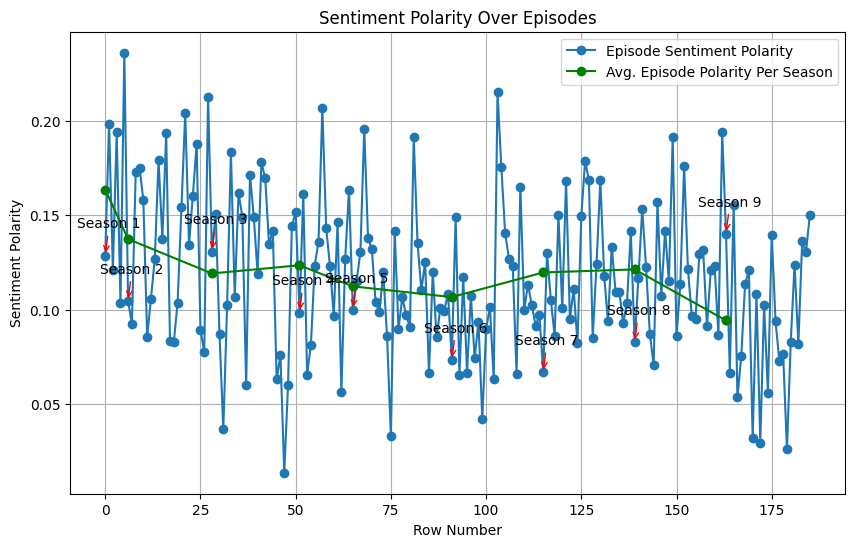

In [ ]:
# Calculate average sentiment polarity for each season
season_avg_sentiment = groupedEpisode.groupby('season')['sentiment_polarity'].mean()

# Find indices of the beginning episode of each season
season_beginning_indices = groupedEpisode.groupby('season').head(1).index

# Find indices where season changes occur
season_change_indices = groupedEpisode.index[groupedEpisode['season'].diff() != 0].tolist()

# Plot sentiment polarity over rows
plt.figure(figsize=(10, 6))
plt.plot(groupedEpisode.index, groupedEpisode['sentiment_polarity'], marker='o', linestyle='-', label='Episode Sentiment Polarity')

# Annotate season change points
for index in season_change_indices:
    plt.annotate(f'Season {groupedEpisode.at[index, "season"]}', xy=(index, groupedEpisode.at[index, 'sentiment_polarity']),
                 xytext=(-20, 20), textcoords='offset points', arrowprops=dict(arrowstyle="->", color='r'))


# Plot average sentiment polarity for each season
for i in range(len(season_beginning_indices) - 1):
    start_index = season_beginning_indices[i]
    end_index = season_beginning_indices[i+1]
    plt.plot([start_index, end_index], [season_avg_sentiment.iloc[i], season_avg_sentiment.iloc[i+1]], marker='o', linestyle='-', color='g')



# Plot the last average sentiment point
plt.plot(season_beginning_indices[-1], season_avg_sentiment.iloc[-1], marker='o', linestyle='-', color='g', label = 'Avg. Episode Polarity Per Season')

plt.title('Sentiment Polarity Over Episodes')
plt.xlabel('Row Number')
plt.ylabel('Sentiment Polarity')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
groupedEpisode['tokenized_dialogue'] = groupedEpisode['preprocessed_dialogue'].apply(lambda x: word_tokenize(x))

word_lemma = WordNetLemmatizer()
#lemmatize word to root form(ex. cars to car, things to thing)
def lemma(txt):
    l_txt = [word_lemma.lemmatize(w) for w in txt]
    return l_txt

#lemmatize verbs to root form(ex. running to run, making to make)
def lemma_as_verb(txt):
    l_txt = [word_lemma.lemmatize(w, pos='v') for w in txt]  # Assume every word is a verb
    return l_txt


groupedEpisode['tokenized_dialogue'] = groupedEpisode['tokenized_dialogue'].apply(lambda x:lemma(x))
groupedEpisode['tokenized_dialogue'] = groupedEpisode['tokenized_dialogue'].apply(lambda x:lemma_as_verb(x))
groupedEpisode.head()

,season,episode,dialogue,preprocessed_dialogue,tokenized_dialogue
0,1,1,All right Jim Your quarterlies look very good ...,right jim quarterlies look good things library...,"[right, jim, quarterly, look, good, thing, lib..."
1,1,2,Hey uh can I help you out in here Oh Im all se...,hey help set thanks gotcha good id rows thats ...,"[hey, help, set, thank, gotcha, good, id, row,..."
2,1,3,Pam Pamela Pamelamadingdong Making copies Im n...,pam pamela pamelamadingdong making copies maki...,"[pam, pamela, pamelamadingdong, make, copy, ma..."
3,1,4,Michael Oh God Dwight come on I wanted to talk...,michael god dwight come wanted talk downsizing...,"[michael, god, dwight, come, want, talk, downs..."
4,1,5,to Jim Hey you ready All right all right secre...,jim hey ready right right secret sign hey ryan...,"[jim, hey, ready, right, right, secret, sign, ..."


###TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

groupedEpisode['preprocessed_dialogue'] = groupedEpisode['tokenized_dialogue'].apply(lambda x: ' '.join(x))

tfidf_weights = tfidf_vectorizer.fit_transform(groupedEpisode['preprocessed_dialogue'])

tfidf_df = pd.DataFrame(tfidf_weights.toarray(), columns=tfidf_vectorizer.get_feature_names_out())


top_words_per_row = tfidf_df.apply(lambda row: row.nlargest(20).index.tolist(), axis=1)

top_words_and_scores_per_row = tfidf_df.apply(lambda row: [(word, row[word]) for word in row.nlargest(20).index], axis=1)

groupedEpisode['top_20_words'] = top_words_per_row

tfidf_df

,aaaaaaaa,aaaaaand,aaaaah,aaaaahhhhh,aaaaand,aaaaeeexcellent,aaaagh,aaaah,aaaahh,aaaahhh,...,zone,zoo,zooey,zoolander,zoom,zoppity,zoran,zuckerberg,zuckerberged,zwarte
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.023751,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027557,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.017916,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.086199,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Filter DataFrame for Season 7, Episode 21
def plotTopWords(s, e):
  target = top_words_and_scores_per_row[(groupedEpisode['season'] == s) & (groupedEpisode['episode'] == e)].iloc[0]

  # Unpack words and scores
  words, scores = zip(*target)

  # Plot top words and their TF-IDF scores for Season 7, Episode 21
  plt.figure(figsize=(10, 6))
  plt.bar(words, scores)
  plt.title(f'Top 20 Words and Their TF-IDF Scores for Season {s}, Episode {e}')
  plt.xlabel('Words')
  plt.ylabel('TF-IDF Score')
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

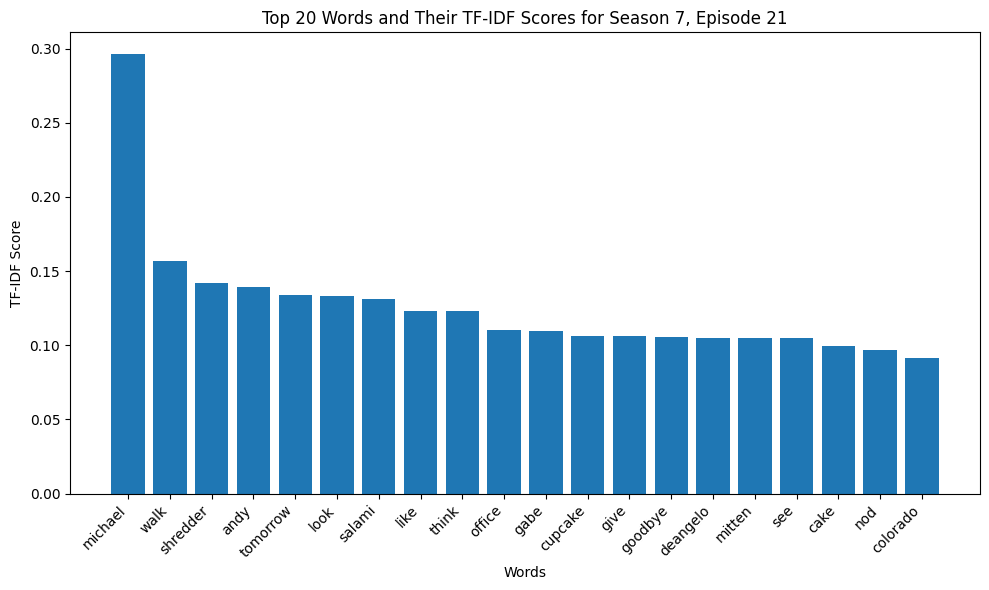

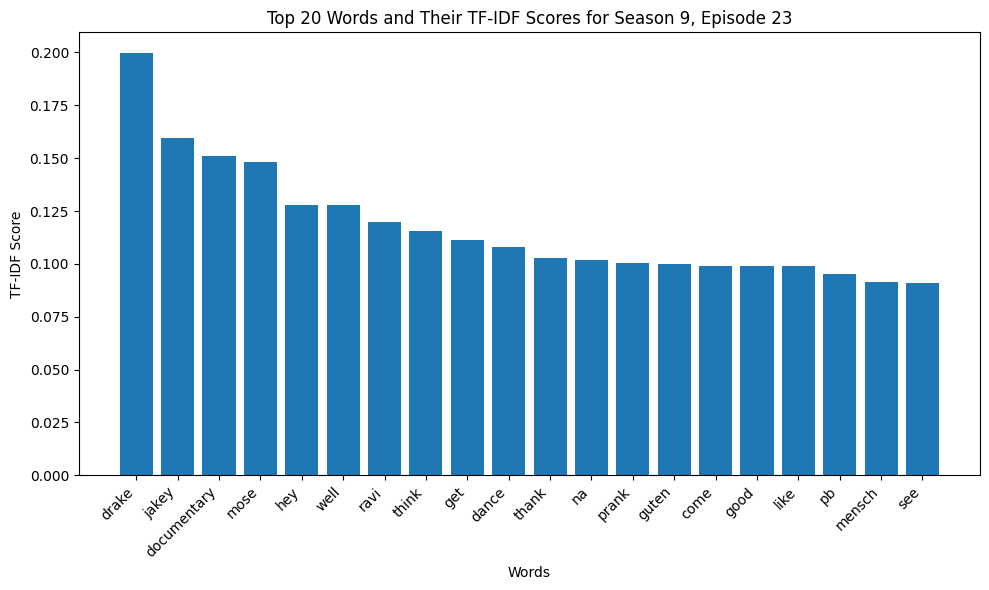

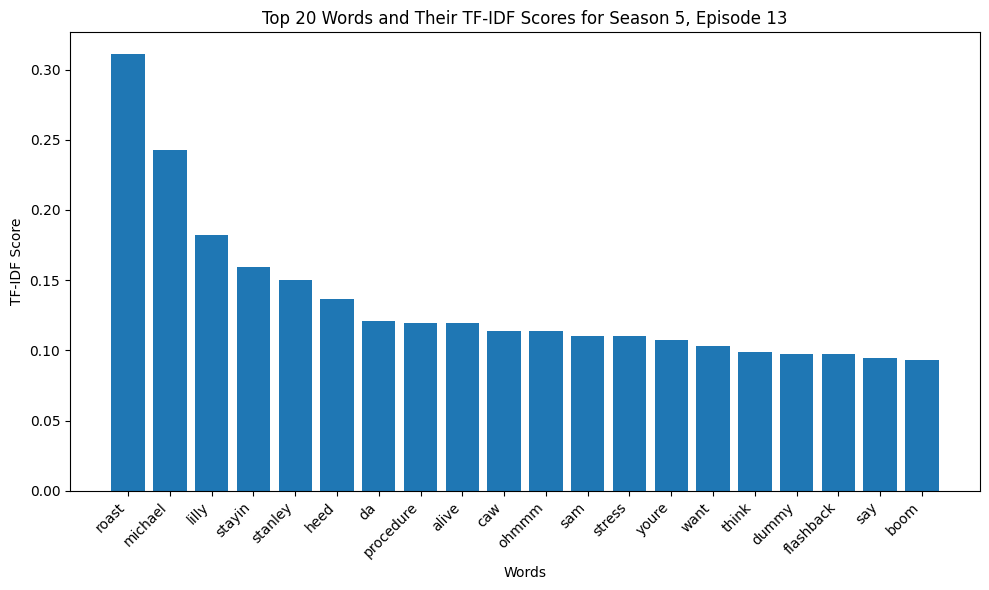

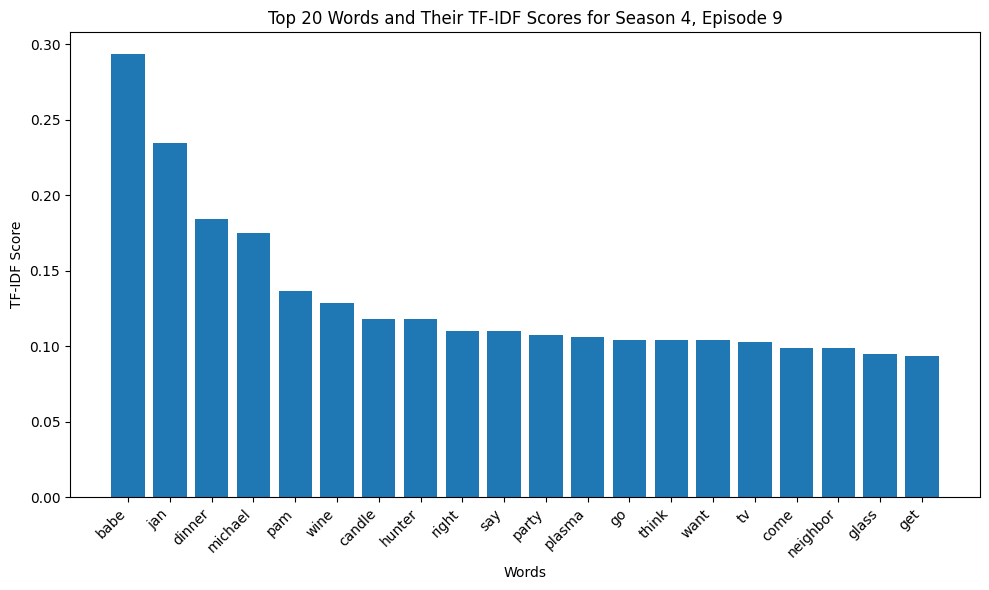

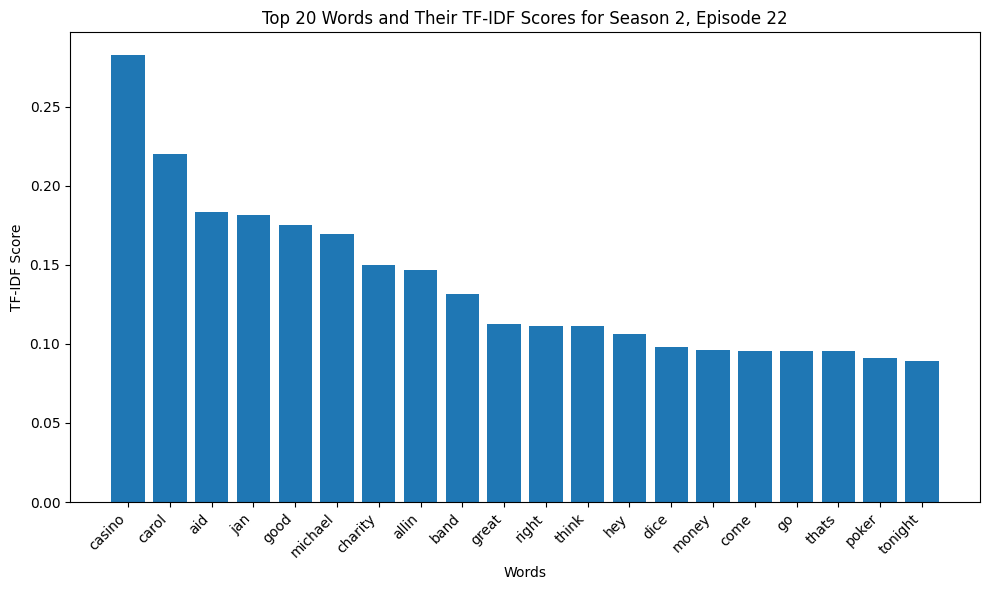

In [ ]:
plotTopWords(7, 21)
plotTopWords(9, 23)
plotTopWords(5, 13)
plotTopWords(4, 9)
plotTopWords(2, 22)

#Top 20 Most Spoken Words

In [ ]:
from collections import Counter
def get_top_20_words(word_list):

    # count the frequency of each word
    word_counts = Counter(word_list)
    return word_counts.most_common(20)

top_20_michael = get_top_20_words(michael_words)
top_20_dwight = get_top_20_words(dwight_words)
top_20_andy = get_top_20_words(andy_words)
top_20_jim = get_top_20_words(jim_words)
top_20_pan = get_top_20_words(pam_words)

print("Top 20 words used by Michael:", top_20_michael)
print("Top 20 words used by Dwight:", top_20_dwight)
print("Top 20 words used by Andy:", top_20_andy)
print("Top 20 words used by Jim:", top_20_jim )
print("Top 20 words used by Pan:", top_20_pan)

Top 20 words used by Michael: [('like', 881), ('well', 821), ('right', 817), ('going', 736), ('good', 728), ("that's", 677), ('think', 591), ('want', 571), ('dwight', 566), ('yes', 563), ('would', 559), ('hey', 553), ('one', 520), ('pam', 484), ('come', 482), ('really', 393), ('people', 386), ('jim', 369), ('see', 367), ('back', 365)]
Top 20 words used by Dwight: [('jim', 438), ('michael', 395), ('like', 339), ('one', 305), ('right', 279), ('good', 253), ('dwight', 249), ("that's", 245), ('yes', 239), ('come', 237), ('hey', 229), ('well', 225), ('would', 210), ('going', 207), ('got', 206), ('want', 189), ('really', 179), ('need', 178), ('back', 171), ('see', 165)]
Top 20 words used by Andy: [('like', 331), ('right', 229), ('well', 187), ('hey', 160), ('one', 160), ('really', 155), ('got', 155), ('think', 151), ("that's", 137), ('gonna', 134), ('going', 132), ('good', 128), ('guys', 127), ('dwight', 122), ('erin', 115), ('would', 113), ('want', 111), ('time', 109), ('back', 106), ('yes'

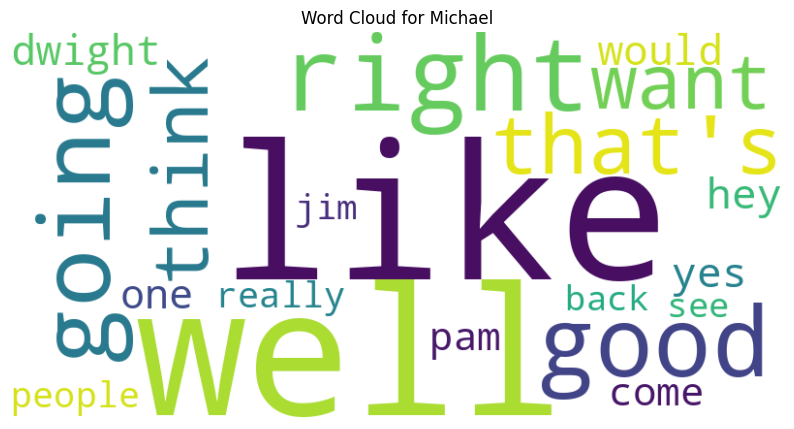

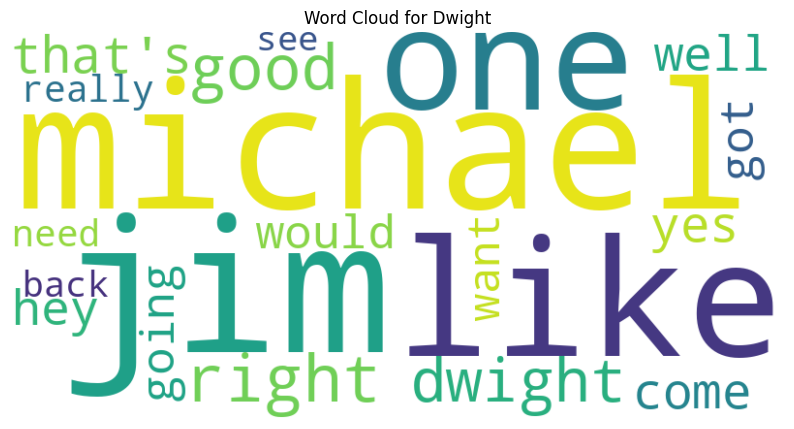

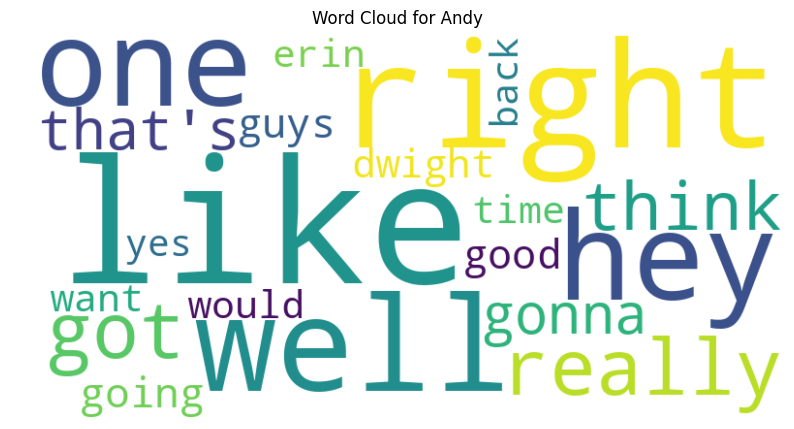

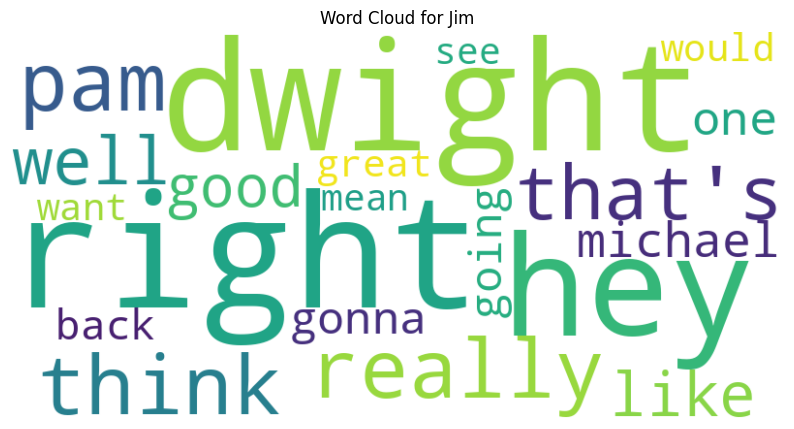

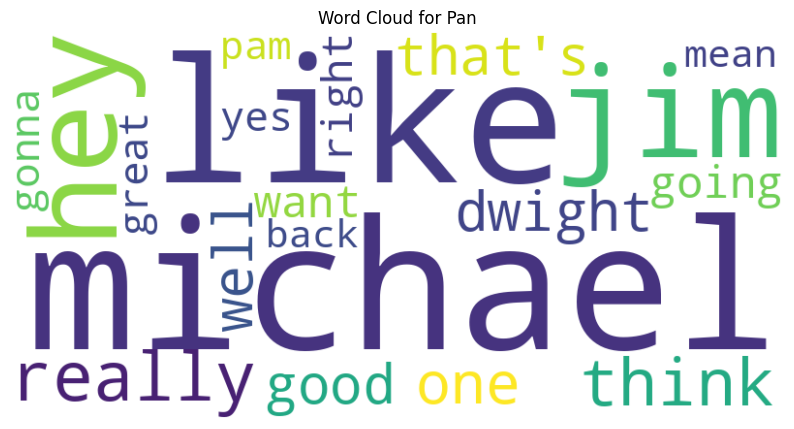

In [ ]:
from wordcloud import WordCloud
# a function to create a word cloud
def generate_word_cloud(top_words, title):

    # create a word cloud from word frequencies
    word_cloud = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate_from_frequencies(dict(top_words))

    # plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

# word cloud for each of the main character's top 20 most commonly spoken words
generate_word_cloud(top_20_michael, "Word Cloud for Michael")
generate_word_cloud(top_20_dwight, "Word Cloud for Dwight")
generate_word_cloud(top_20_andy, "Word Cloud for Andy")
generate_word_cloud(top_20_jim, "Word Cloud for Jim")
generate_word_cloud(top_20_pan, "Word Cloud for Pam")

In [ ]:
# a function to clean and tokenize the text
def clean_and_tokenize(text):

    # remove leading/trailing spaces
    text = text.strip()

    # allow only words, apostrophes, and dashes
    text = re.sub(r"[^\w'-]"," ",text)

    # replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)

    return nltk.word_tokenize(text)
# a function to get only the top 10 adjectives
def get_top_10_adjectives(adjective_list):
    adjective_counts = Counter(adjective_list)
    return adjective_counts.most_common(10)

    # a function to extract the adjectives
def extract_adjectives(text):
    words = clean_and_tokenize(text)

    # Apply part-of-speech tagging to identify adjectives
    tagged_words = nltk.pos_tag(words)
    adjectives = [word for (word, tag) in tagged_words if tag.startswith("JJ")]
    return adjectives

# a function to retrieve the adjectives
def get_all_adjectives(dialogues):
    adjectives = []
    for dialogue in dialogues:
        adjectives.extend(extract_adjectives(dialogue))
    return adjectives

In [ ]:
# top_10_michael = get_top_10_adjectives(get_all_adjectives(michael_words))
# top_10_dwight= get_top_10_adjectives(get_all_adjectives(dwight_words))
# top_10_jim= get_top_10_adjectives(get_all_adjectives(jim_words))
# top_10_pam= get_top_10_adjectives(get_all_adjectives(pam_words))
# top_10_andy= get_top_10_adjectives(get_all_adjectives(andy_words))

KeyboardInterrupt: 

In [ ]:
from multiprocessing import Pool

# Define a function to process each character's words
def process_character_words(character_words):
    return get_top_10_adjectives(get_all_adjectives(character_words))

# Create a pool of worker processes
pool = Pool()

# Map the processing function to each character's words
results = pool.map(process_character_words, [michael_words, dwight_words, jim_words, pam_words, andy_words])

# Close the pool to free up resources
pool.close()
pool.join()

# Unpack the results
top_10_michael, top_10_dwight, top_10_jim, top_10_pam, top_10_andy = results


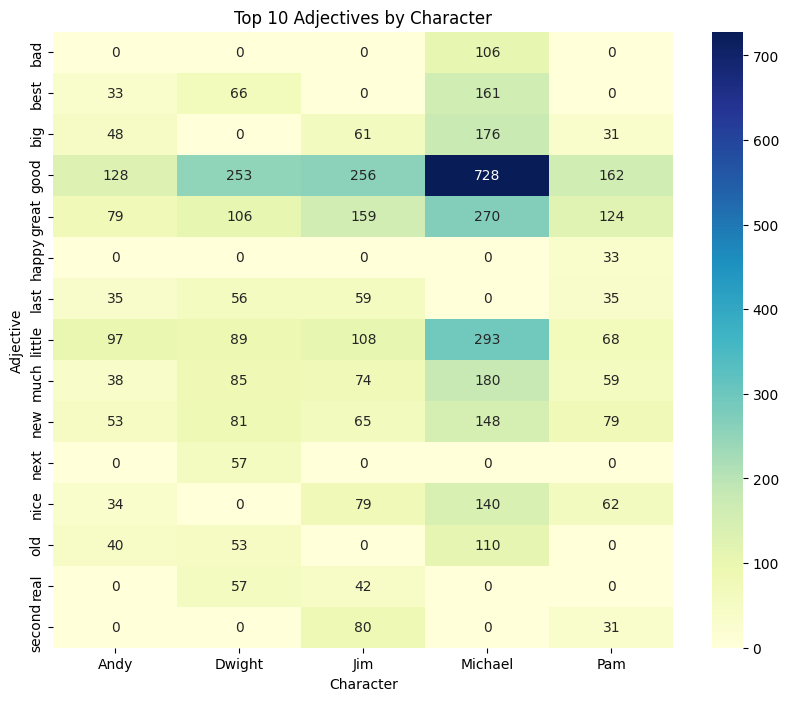

In [ ]:
import seaborn as sns
data = []
main_characters = ["Michael", "Dwight", "Jim", "Pam", "Andy"]

# append data for each character
for char, top_10 in zip(main_characters, [top_10_michael, top_10_dwight, top_10_jim, top_10_pam, top_10_andy]):
    for adjective, count in top_10:
        data.append({'character': char, 'adjective': adjective, 'frequency': count})

# create a DataFrame from the list of dictionaries
df = pd.DataFrame(data)

# create a pivot table to get the frequency of each adjective by character
pivot_table = df.pivot_table(
    values='frequency',
    index='adjective',
    columns='character',
    fill_value=0,
    aggfunc='sum'
)

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    pivot_table,
    annot=True,
    cmap="YlGnBu",
    fmt='d',
    cbar=True
)

plt.title("Top 10 Adjectives by Character")
plt.xlabel("Character")
plt.ylabel("Adjective")
plt.show()

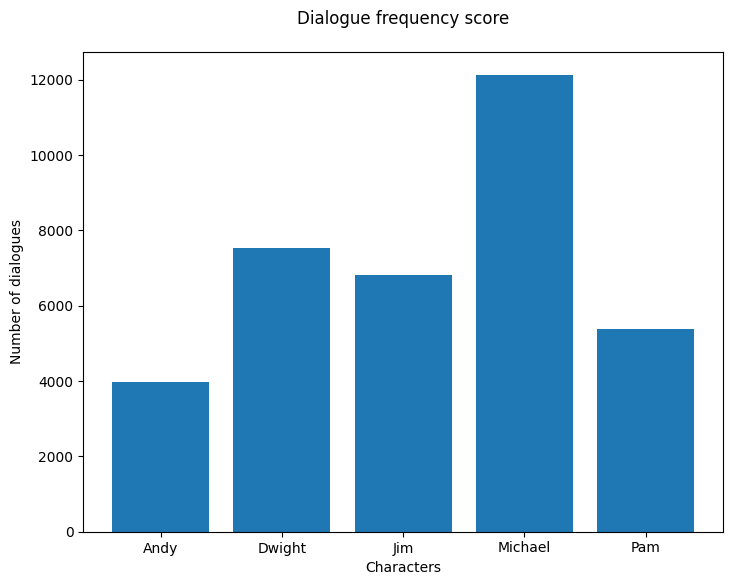

In [ ]:
lchar = [ 'Andy','Dwight','Jim','Michael','Pam']

# most important character by dialogues
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Dialogue frequency score", pad=20)
plt.xlabel('Characters')
plt.ylabel('Number of dialogues')
dialogue_count = main_char_df.groupby(by=["character"]).count()["dialogue"]
ax.bar(lchar, dialogue_count)

plt.show()

In [ ]:
dialogue_count = main_char_df.groupby(by=["character"]).count()["dialogue"]
print(dialogue_count)

character
Andy        3968
Dwight      7529
Jim         6814
Michael    12137
Pam         5375
Name: dialogue, dtype: int64


# New Section